___
<h1><center> Problema de detección de anomalías - Fraude en tarjetas</center></h1>

___

En este caso tenemos las características de cada transacción (X) y la etiqueta indicando si son fraude o no (Y). Podríamos realizar directamente un clasificador de aprendizaje supervisado, pero el objetivo es que tener una aproximación a cómo de útil puede ser un modelo de detección de anomalías en pasos previos.

Vamos a suponer que no existe una etiqueta (Y), se realizara un modelo de detección de anomalías sólamente con las características (X). Se hallaran las transacciones como anómalas y luego compararé con las etiquetas reales (Y). De este modo podremos ver cómo un detector de anomalías podría servir en ese primer filtrado.

## Cargar las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import scikitplot as skplt
new_style = {'grid': False}
plt.rc('axes', **new_style)
import requests
import os.path
import io

## Definicion de funciones

In [4]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def repre_matriz_confusion(matriz):
    df_matriz_confusion = pd.DataFrame(matriz,
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Matriz de confusión')
    _ = sns.heatmap(df_matriz_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
def reporting_modelo(y_reales, y_clase):
    matriz_confusion = metrics.confusion_matrix(y_reales, y_clase)
    roc_auc = metrics.roc_auc_score(y_reales, y_clase)
    metrica_f1 = metrics.f1_score(y_reales, y_clase)
    print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,2)))
    print(u'La F1 es de: {}'.format(round(metrica_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_reales, y_clase),3)))  
    print("Sensitividad\t{}".format(round(metrics.recall_score(y_reales, y_clase),3)))
    print(u"Precisión\t{}".format(round(metrics.precision_score(y_reales, y_clase),3)))   
    repre_matriz_confusion(matriz_confusion)
    
def repres_doble_hist(y_prob_pos, y_prob_neg):
    
    fig = plt.figure(figsize=(20,10))
    ax = sns.distplot(y_prob_pos,norm_hist=True, bins=30, hist=False,
    label='', kde_kws={"color": "r", "lw": 5})  
    ax2 = ax.twinx()
    sns.distplot(y_prob_neg,norm_hist=True ,ax=ax2, bins=30, hist=False,
    label='', kde_kws={"color": "g", "lw": 2}) 
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.figure.legend(['Clase fraudulenta', 'Clase no fraudulenta'])
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    plt.title('Representación de las probabilidades asignadas a ambas clases')
    plt.show()

## Lectura de datos

In [5]:
url = "https://masterdatascience.s3.us-east-2.amazonaws.com/6.machine_learning/creditcard.csv"
s = requests.get(url).content

XY = pd.read_csv(io.StringIO(s.decode('latin1')), encoding = 'latin1', sep = ',')

In [6]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 284807
- El número de columnas en el dataset es: 31
- Los nombres de las variables son: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


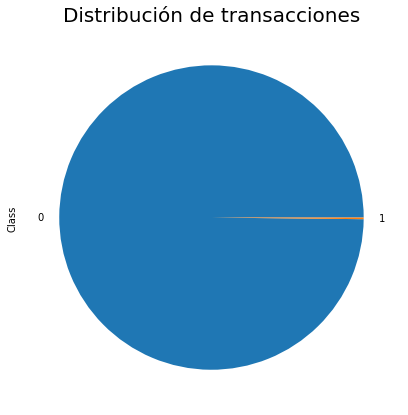

In [8]:
XY['Class'].value_counts().plot(kind='pie', figsize=(7,7))
_ = plt.title('Distribución de transacciones', fontsize=20)

La variable "class" es la respuesta, indica si esa transaccion es fraudolenta (1) o no es fraudolenta (0), las clases estan debalanceadas ya que como se ve hay apenas unos casos fraudolentos

## Division en features X + target Y

In [10]:
X = XY.drop('Class', axis=1)
Y = XY['Class']

## Representacion del PCA de las clases 

In [11]:
df_plt=XY[XY['Class']==0].sample(2000)
df_plt_pos=XY[XY['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',axis=1)

In [12]:
pca2 = PCA(n_components=3)
X_PCA = pca2.fit_transform(X_plt)

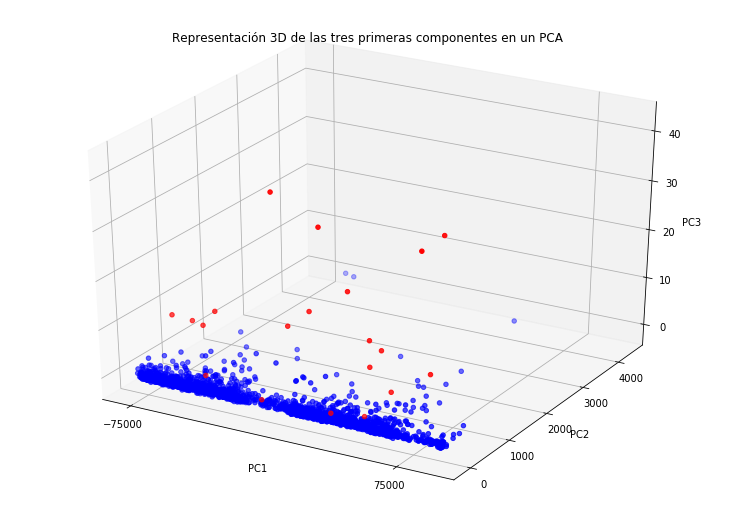

In [13]:
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y_plt, cmap=plt.cm.get_cmap("bwr"))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([-75000,75000])
ax.set_title('Representación 3D de las tres primeras componentes en un PCA')
plt.show()

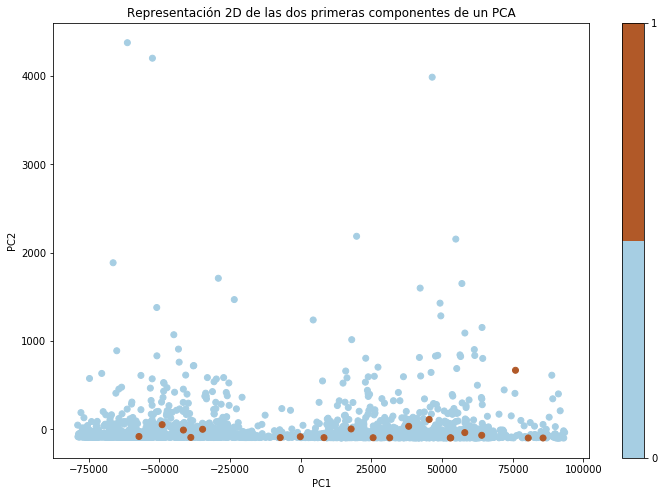

In [14]:
plt.figure(figsize=(12,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('Representación 2D de las dos primeras componentes de un PCA')
plt.xlabel('PC1'); _=plt.ylabel('PC2')

## Ajuste del modelo de deteccion de anomalias a X

Voy a utilizar el método Local Outlier Factor. Este método sólo se fija en los vecinos locales de cada punto por lo que vamos a ajustar el modelo a todos los datos X.

Un parámetro que se puede ir cambiando es el **número de vecinos.** A menor número más se ajusta el modelo.

In [15]:
clf=LocalOutlierFactor(n_neighbors=10, 
                        algorithm='auto', 
                        leaf_size=30,
                        metric='minkowski', 
                        p=2, 
                        metric_params=None, 
                        n_jobs=-1,
                        novelty=False)

In [17]:
%%time
clf.fit(X)

CPU times: user 1min 19s, sys: 156 ms, total: 1min 19s
Wall time: 58.5 s


LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=-1,
                   n_neighbors=10, novelty=False, p=2)

## Deteccion de anomalias

El modelo nos proporciona lo que se denominan factores de anomalías negativos. Cuanto más alto es este valor, más normal es el punto. Es decir, si queremos quedarnos con el 2 % de puntos más anómalos, debemos quedarnos con el 2 % de valores más bajo.

In [18]:
factores_lof = clf.negative_outlier_factor_
factores_lof

array([-1.19618609, -1.15222336, -1.61787169, ..., -1.32806678,
       -1.24067803, -1.75327498])

In [19]:
Y_pred_clase = factores_lof.copy()
Y_pred_clase[factores_lof>=np.percentile(factores_lof,2.)] = 0
Y_pred_clase[factores_lof<np.percentile(factores_lof,2.)] = 1

La AUC de la ROC es de: 0.67
La F1 es de: 0.06

Accuracy	0.98
Sensitividad	0.358
Precisión	0.031


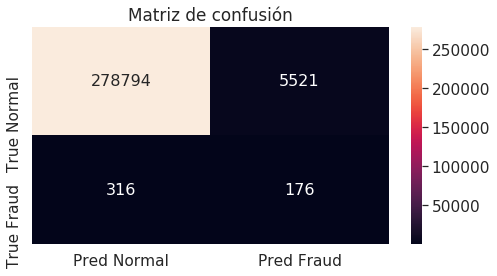

In [20]:
reporting_modelo(Y, Y_pred_clase) 

Como vemos, con un dos por ciento de la muestra detectada como fraude, detectamos más del 50 % de las transacciones fraudulentas.

## Representacion de las probabilidades

Normalizo los factores al rango (0,1) para obtener una estimación de probabilidades:

In [21]:
Y_probs = NormalizeData(factores_lof)
Y_pred_prob_pos = NormalizeData(factores_lof)[np.where(Y == 1)]
Y_pred_prob_neg = NormalizeData(factores_lof)[np.where(Y == 0)]

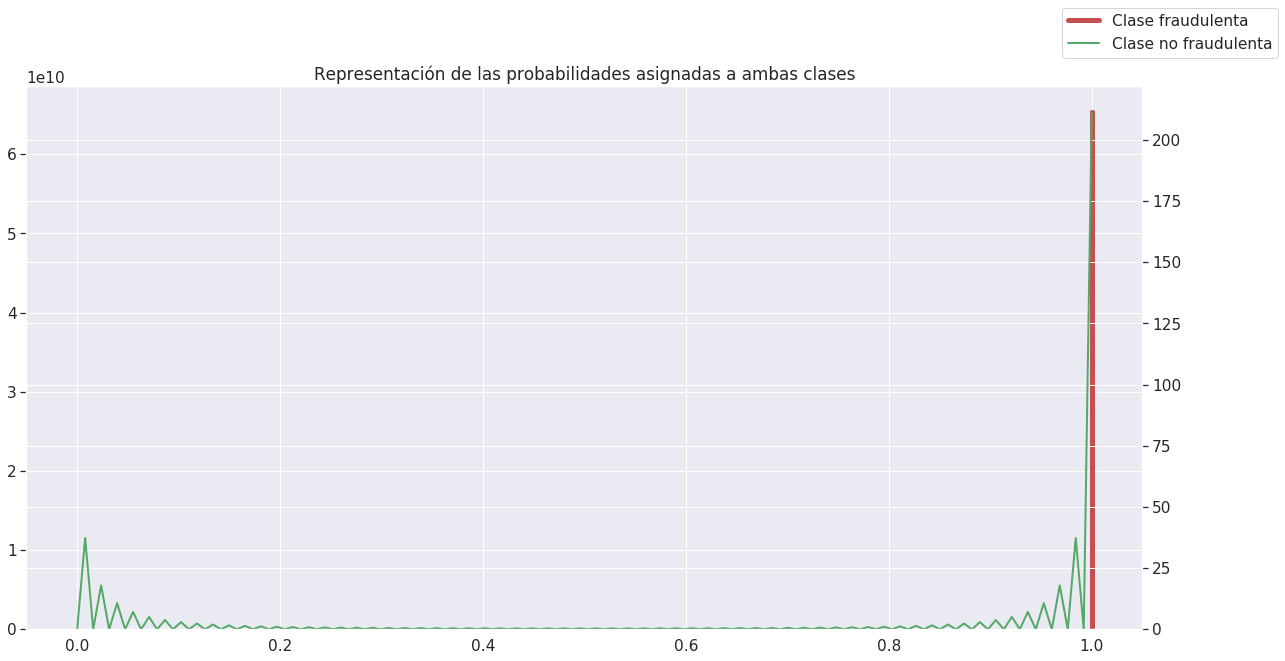

In [22]:
repres_doble_hist(Y_pred_prob_pos, Y_pred_prob_neg)

## Representacion de la ganancia a no tener modelo:

En este punto analizamos qué mejora nos da el modelo. Es decir, que ventaja tiene una empresa usando un modelo de detección de anomalías a no usarlo.

Creo un array con una estimación de probabilidades de 1s y de 0s (tengo las de 1s, simplemente hay que crear otra como 𝑃0=1−𝑃1

In [23]:
Y_probs_1_0 = np.column_stack((Y_probs,list(map(lambda x: 1-x, Y_probs))))
Y_probs_1_0

array([[1.00000000e+00, 5.51059198e-12],
       [1.00000000e+00, 4.68358685e-12],
       [1.00000000e+00, 1.34428024e-11],
       ...,
       [1.00000000e+00, 7.99127431e-12],
       [1.00000000e+00, 6.34747810e-12],
       [1.00000000e+00, 1.59897651e-11]])

Podemos representar la ganancia acumulada que obtenemos entre tener modelo y no tenerlo:

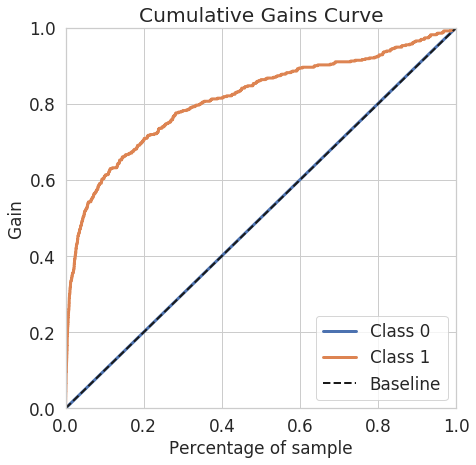

In [25]:
skplt.metrics.plot_cumulative_gain(Y, Y_probs_1_0, figsize=(7,7))
plt.show()

Y la curva de Lift, que es muy usada en los modelos de clasificación, ya que nos indica para cada porcentaje de las transacciones más probables de ser fraude cuál es la ganancia que obtenemos con el modelo. En este caso, si cogemos al 10 % de más transacciones más probables, mejoramos a una decisión aleatoria en un 1000 % aproximadamente.

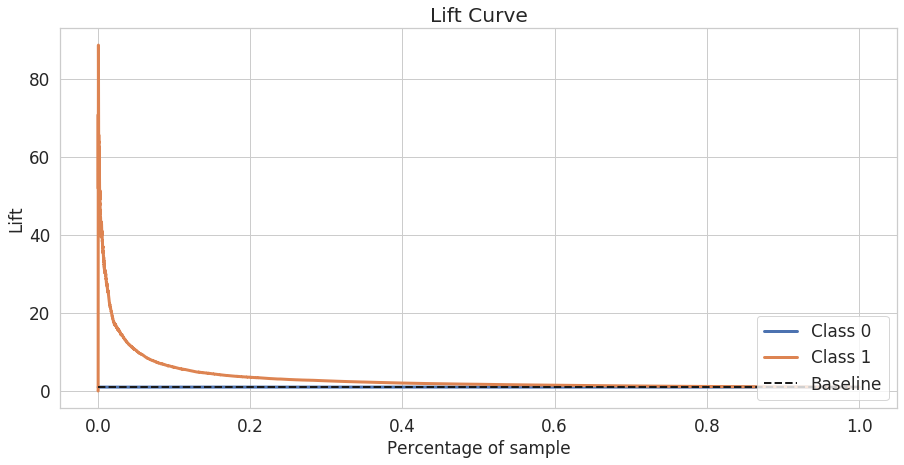

In [26]:
skplt.metrics.plot_lift_curve(Y, Y_probs_1_0, figsize=(15,7))
plt.show()

En este punto, la empresa simplemente auditando un pequeño porcentaje de todas las transacciones totales, daría con la mayoría de las transacciones fraudulentas.